# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [8]:
import sys
sys.path.append('../')

In [9]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import coordinates

matplotlib settings set


***

eROSITA catalog in 0.2-2.3 keV range

In [10]:
ero_df_orig = pd.read_pickle(data_path+'ERO_lhpv_02_23_sd01_a15_g14.pkl') 

def erosita_x_ray_filter(ero_df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,) -> pd.DataFrame:
    """
    erosita_x_ray_filter cleans erosita catalog from sources with small detection likelihood and extended sources, also removes duplicates from the

    Args:
        ero_df (pd.DataFrame): DataFrame of eROSITA data from Lockman Hole. Normally it would be `ERO_lhpv_03_23_sd01_a15_g14_orig.pkl` file
        DL_thresh (float, optional): minimum Detection likelihood . Defaults to 6.
        EL_thresh (float, optional): Maximum extension likelihood. Defaults to 6.
    
    Returns:
        pd.DataFrame: DataFrame with cleaned eROSITA data
    """  



    def cross_match_with_itself(xcat):
        xcat_matched = xcat.copy()
        c = SkyCoord(ra=xcat['RA_fin']*u.degree, dec=xcat['DEC_fin']*u.degree)
        catalog = SkyCoord(ra=xcat['RA_fin']*u.degree, dec=xcat['DEC_fin']*u.degree)
        idx, ero2ero, _ = c.match_to_catalog_sky(catalog, nthneighbor=2)
        ero2ero = ero2ero.to(u.arcsec).value

        xcat_matched['sep_to_closest'] = ero2ero
        xcat_matched.loc[:, 'srcname_fin_closest']  = xcat_matched.iloc[idx]['srcname_fin'].values
        xcat_matched = xcat_matched.merge(xcat.rename(columns={'srcname_fin':'srcname_fin_closest'}), on='srcname_fin_closest', how='left', suffixes=('', '_closest'))

        xcat_matched['is_confused'] = xcat_matched.eval('sep_to_closest<10') # close pairs for sep < 10. They are marked and the brightest one is kept

        xcat_matched['ML_FLUX_0_ratio'] = xcat_matched.ML_FLUX_0/xcat_matched.ML_FLUX_0_closest
        xcat_matched['ML_CTS_0_ratio']  = xcat_matched.ML_CTS_0/xcat_matched.ML_CTS_0_closest
        xcat_matched['DET_LIKE_0_ratio'] = xcat_matched.DET_LIKE_0/xcat_matched.DET_LIKE_0_closest
        xcat_matched['sep_ero2ero'] = xcat_matched['sep_to_closest']
        xcat_matched['pos_r98_first'] = xcat_matched['pos_r98']
        xcat_matched['pos_r98_second'] = xcat_matched['pos_r98_closest']
        xcat_matched['should_be_deleted'] = (xcat_matched['is_confused']) &  (xcat_matched['ML_FLUX_0_ratio']<1) #so that we delete the one with lower ML_FLUX_0


        xcat_matched = xcat_matched[['srcname_fin', 'srcname_fin_closest', 'is_confused', 'ML_FLUX_0_ratio', 'ML_CTS_0_ratio', 'DET_LIKE_0_ratio', 'sep_ero2ero', 'pos_r98_first', 'pos_r98_second', 'should_be_deleted']]

        return xcat_matched


    ero_df = ero_df.copy()
    ero_df.reset_index(inplace=True, drop=True)
    print(f'Original number of sources: {len(ero_df)}')
    ero_df = ero_df.query(f'DET_LIKE_0>{DL_thresh} and EXT_LIKE<{EL_thresh}')
    print(f'Number of sources after DL and EL cuts: {len(ero_df)}')

    ero_df.sort_values(by = 'ML_FLUX_0', ascending=False, inplace=True)
    ero_df.drop_duplicates(subset=['srcname_fin'], inplace=True) #drop duplicated srcname from the catalog, keeping the one with the highest ML_FLUX_0


    #cross match with itself to remove duplicates
    ero_df_cross_matched  = cross_match_with_itself(ero_df)
    id_to_retain = ero_df_cross_matched[ero_df_cross_matched.should_be_deleted==False]['srcname_fin']
    ero_df = ero_df[ero_df.srcname_fin.isin(id_to_retain)]

    print(f'Number of sources after DL and EL cuts + duplicates removal: {len(ero_df)}')
    ero_df.reset_index(drop=True, inplace=True) #drop index

    return ero_df


ero_df = erosita_x_ray_filter(ero_df_orig)
ero_df.sample(5)

Original number of sources: 9573
Number of sources after DL and EL cuts: 9302
Number of sources after DL and EL cuts + duplicates removal: 9291


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
6525,SRGe J104453.6+562713,161.223416,56.453716,151.733360,53.012445,9.527475,14.124495,5.449421e-15,1.482655e-15,25.199476,6.856162,4224.629395,0.0,0.0,0.0,7900,6779,161.225425,56.452427,3.865521,54.207775,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.005965,0.001623,22.001648,161.223416,56.453716,68675106172,3.865521,3.406137,5.141878,8.337361,136.602746,43.940575,4.120186e-15,5.893238e+19
3019,SRGe J103258.6+563352,158.243970,56.564502,153.218479,51.637237,6.833298,43.446865,1.173766e-14,2.048719e-15,55.003216,9.600389,4281.085938,0.0,0.0,0.0,2882,2315,158.245979,56.563212,2.742962,63.694599,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012848,0.002243,23.916851,158.243970,56.564502,68235523549,2.742962,2.442950,3.687859,5.979724,134.579093,43.188970,8.874586e-15,5.845695e+19
4385,SRGe J105428.7+582535,163.619560,58.426294,147.874681,52.664760,8.818895,21.753185,8.262707e-15,1.851636e-15,38.881367,8.713141,4298.992188,0.0,0.0,0.0,2414,1936,163.621569,58.425005,3.571329,48.482883,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.009044,0.002027,21.671347,163.619560,58.426294,61036654254,3.571329,3.152815,4.759465,7.717292,136.640494,46.296797,6.247249e-15,6.907885e+19
824,SRGe J103954.3+552521,159.976166,55.422624,153.801146,53.091751,3.455260,227.326691,3.204882e-14,2.943263e-15,162.308060,14.905863,4626.744629,0.0,0.0,0.0,772,630,159.978175,55.421334,1.294061,95.134239,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.035080,0.003222,22.534595,159.976166,55.422624,72831372025,1.294061,1.235279,1.864767,3.023649,136.511096,42.696955,2.423140e-14,5.789198e+19
6083,SRGe J103412.3+572818,158.551140,57.471783,151.884456,51.237722,8.028379,15.467110,5.869790e-15,1.580354e-15,27.533831,7.413076,4285.402344,0.0,0.0,0.0,8161,7034,158.553149,57.470493,3.242373,97.611900,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.006425,0.001730,21.095840,158.551140,57.471783,64681211591,3.242373,2.870200,4.332832,7.025523,134.137302,44.054325,4.438017e-15,6.089175e+19


In [26]:
2e-4 * 9200

1.84

In [ ]:
ero_df_first_cat = pd.read_pickle('ERO_lhpv_03_23_sd01_a15_g14.pkl')

In [11]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03



def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r




r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
518111,9011,275,614508,157.357406,59.037124,0.243820,0.248023,0.057331,1.711139,-0.388440,-8.486617,339.30212,586.48834,237.84805,99.895744,4.540371,1.083767,0.001292,0.000015,24.010660,23.999176,25.595863,21.915546,NaN,NaN,16.173471,5.904712,3.825087,0.573010,3.646120,-0.404382,-0.305053,1.327823,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.394229,57820.342431,2018-03-17 09:27:41.402,2017-03-08 08:13:06.000,9011_614508_275
500743,9011,2591,615249,156.513120,59.350706,0.364172,0.437259,1.386021,4.768686,2.746721,15.692313,135.43425,458.29425,172.01917,51.289700,4.159053,1.032929,0.001483,0.000017,23.569904,23.380080,22.135468,20.802467,21.402021,19.510582,17.170603,7.796128,5.734924,9.926240,9.725142,2.791578,0.604370,0.561784,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.252885,57842.276202,2018-04-18 06:04:09.258,2017-03-30 06:37:43.840,9011_615249_2591
999533,9011,1910,609170,163.171777,57.343854,0.119206,0.652664,3.622348,15.236234,8.666774,25.755957,-161.85207,565.88240,190.13880,119.368710,4.125679,1.101989,0.001462,0.000018,24.787298,22.948488,21.094254,19.541550,20.154585,18.972641,NaN,2.835715,8.999633,39.576320,30.947483,9.098003,0.984905,-0.688486,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.405780,57784.444599,2018-03-17 09:44:19.410,2017-01-31 10:40:13.339,9011_609170_1910
2132818,9011,1791,607573,153.885508,56.712503,0.250588,0.220979,0.339467,1.685933,2.400248,-1.640838,1386.93080,992.87470,334.62048,110.321340,4.132833,1.051842,0.001182,0.000015,23.968224,24.115965,23.660053,21.930931,21.548151,NaN,14.644766,7.896018,4.042296,3.565560,3.427396,2.461679,-0.056405,5.415286,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.380919,57784.423100,2018-03-17 09:08:31.442,2017-01-31 10:09:15.871,9011_607573_1791
808334,9011,2720,612267,167.117030,58.206759,0.308074,0.411453,0.878740,1.520585,-0.803343,17.338379,-210.42900,698.02606,273.80430,106.009450,4.941703,1.265422,0.001123,0.000014,23.746761,23.442913,22.628443,22.043163,NaN,19.402243,NaN,8.139366,6.808328,9.047582,3.380252,-0.903688,0.581018,-0.781850,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57895.181835,57545.190525,2017-05-22 04:21:50.501,2016-06-06 04:34:21.340,9011_612267_2720


# CSC

In [12]:
csc_df = pd.read_pickle(data_path+'csc_all_lh.pkl')
csc_df.sample(5)

,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,radec_err,r_98,flux_05_2,flux_05_2_err,secure
125300,2CXO J104841.8+585814,162.174389,58.970615,1.000140,0.895749,23.837171,8.539061,236.195544,TRUE,False,False,False,False,False,False,False,5.365575e-15,4.400855e-15,6.330296e-15,2.364073e-15,1.829342e-15,2.870660e-15,0.548515,1.534280,7.729648e-15,1.550464e-15,True
114449,2CXO J103233.5+573720,158.139856,57.622388,0.892315,0.849551,89.849862,3.878788,70.407548,TRUE,False,False,False,False,False,False,False,5.253582e-16,2.932232e-16,7.574932e-16,5.525466e-16,3.204770e-16,7.735653e-16,0.503343,1.407926,1.077905e-15,4.587798e-16,True
114703,2CXO J103344.2+574345,158.434389,57.729329,1.349003,0.895169,63.891700,2.157895,15.079856,MARGINAL,False,False,False,False,False,False,False,NaN,NaN,NaN,0.000000e+00,0.000000e+00,1.366606e-16,0.661422,1.850096,NaN,NaN,True
114702,2CXO J103344.0+574843,158.433536,57.811949,1.635304,1.096577,122.590808,2.051282,14.001348,MARGINAL,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,1.145280e-16,NaN,NaN,NaN,0.804386,2.249989,NaN,NaN,True
114489,2CXO J103246.5+575852,158.194091,57.981134,0.947344,0.843755,102.827964,7.518700,226.080584,TRUE,False,False,False,False,False,False,True,8.584030e-15,6.867224e-15,1.030084e-14,2.994880e-15,2.199365e-15,3.743600e-15,0.518278,1.449702,1.157891e-14,2.662381e-15,True


## CSC x ERO cross-match

In [13]:
ero_csc_orig = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc_orig.query("csc_n_near==1 & csc_n_matches==1")

ero_csc = ero_csc.query("csc_secure==True")
print('SECURITY FILTER APPLIED (CSC)')
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])
assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 916 out of 9291 x 2329
	 total unique pairs: 858
	 total non-unique pairs (duplicates in df2): 58
SECURITY FILTER APPLIED (CSC)
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 554


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_radec_err,csc_r_98,csc_flux_05_2,csc_flux_05_2_err,csc_secure,csc_sep,csc_n_near,csc_n_matches
56,SRGe J104511.1+591626,161.296313,59.273903,148.202218,51.208212,2.841723,448.250854,5.235574e-14,3.721680e-15,245.314880,17.438080,4280.624023,0.0,0.0,0.0,410,343,161.298321,59.272614,1.012118,153.064194,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.057308,0.004074,19.616659,161.296313,59.273903,57880912968,1.012118,1.015935,1.533648,2.486752,134.512367,46.345241,3.958501e-14,8.715576e+19,2CXO J104511.1+591625,161.296561,59.273768,0.712503,0.711654,70.202361,14.257766,3956.822546,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,2.074348e-14,1.922112e-14,2.217069e-14,0.411412,1.150780,NaN,NaN,True,0.668296,1,1
119,SRGe J110720.4+585641,166.834995,58.944594,145.261969,53.435920,7.634658,26.745306,3.028848e-14,7.267113e-15,24.996126,5.997320,753.950439,0.0,0.0,0.0,4028,3244,166.837004,58.943304,3.078166,82.865349,0.000017,6.268413e+08,6.270701e+08,0.0,0.0,0.033154,0.007955,4.496779,166.834995,58.944594,59097819663,3.078166,2.729442,4.120345,6.680983,138.235262,47.666948,2.290044e-14,6.799573e+19,2CXO J110720.1+585633,166.833933,58.942636,2.337821,1.459983,77.755139,7.788270,188.944618,TRUE,False,False,False,False,False,False,False,1.631740e-14,6.174152e-15,2.646065e-14,1.343307e-14,1.101072e-14,1.585543e-14,1.126039,3.149699,2.975047e-14,1.474811e-14,True,7.317977,1,1
726,SRGe J105032.3+564801,162.634420,56.800398,150.454951,53.381359,9.086307,14.416292,5.471202e-15,1.527830e-15,25.163414,7.026870,4201.789551,0.0,0.0,0.0,5516,4543,162.636428,56.799109,3.682420,47.498642,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.005989,0.001672,21.816538,162.634420,56.800398,67303366876,3.682420,3.248416,4.903784,7.951301,137.267537,44.644978,4.136654e-15,6.959713e+19,2CXO J105032.1+564804,162.634075,56.801189,9.987116,9.987116,0.000000,2.810811,19.494125,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,2.601999e-15,7.753525e-15,4.245978e-15,1.126107e-14,5.770170,16.140029,7.753525e-15,5.601444e-15,True,2.925659,1,1
818,SRGe J104644.3+590030,161.684484,59.008302,148.304176,51.533994,10.416447,11.149406,4.378249e-15,1.340022e-15,20.712469,6.339327,4321.941406,0.0,0.0,0.0,7439,6338,161.686492,59.007012,4.233924,123.150612,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.004792,0.001467,21.323711,161.684484,59.008302,58861514919,4.233924,3.723950,5.621646,9.115288,134.963581,46.231379,3.310297e-15,8.471535e+19,2CXO J104644.0+590028,161.683744,59.007933,1.272012,0.919542,114.836381,4.666667,73.592232,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,1.406367e-15,0.000000e+00,0.000000e+00,1.008016e-15,0.641234,1.793626,0.000000e+00,1.730307e-15,True,1.908633,1,1
811,SRGe J105212.0+580103,163.050020,58.017631,148.704253,52.729691,9.993339,11.022181,4.415490e-15,1.375631e-15,20.512087,6.390473,4244.029785,0.0,0.0,0.0,7343,6244,163.052029,58.016342,4.058665,92.890320,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.004833,0.001506,23.447954,163.050020,58.017631,62585063902,4.058665,3.572686,5.393300,8.745031,136.602566,45.790565,3.338454e-15,7.244428e+19,2CXO J105211.8+580102,163.049551,58.017265,3.030884,3.030884,0.000000,3.028571,131.182923,TRUE,False,False,False,False,False,False,False,0.000000e+00,0

## CSC x DESI cross-match

In [14]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2523 out of 554 x 2418574
	 total unique pairs: 2523
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_radec_err,csc_r_98,csc_flux_05_2,csc_flux_05_2_err,csc_secure,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.2+594123,165.675912,59.689622,145.179993,52.485971,5.658686,222.882278,2.019607e-13,1.963106e-14,145.023376,14.096615,656.022339,0.0,0.0,0.0,798,649,165.677921,59.688332,2.248189,236.400360,0.000029,6.268413e+08,6.270701e+08,0.0,0.0,0.221065,0.021488,4.37352,165.675912,59.689622,56361990050,2.248189,2.023019,3.053933,4.951837,136.876984,47.936160,1.526980e-13,6.398546e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,True,4.923179,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.074990,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.2+594123,165.675912,59.689622,145.179993,52.485971,5.658686,222.882278,2.019607e-13,1.963106e-14,145.023376,14.096615,656.022339,0.0,0.0,0.0,798,649,165.677921,59.688332,2.248189,236.400360,0.000029,6.268413e+08,6.270701e+08,0.0,0.0,0.221065,0.021488,4.37352,165.675912,59.689622,56361990050,2.248189,2.023019,3.053933,4.951837,136.876984,47.936160,1.526980e-13,6.398546e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,True,4.923179,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544262,-131.121550,-1138.750900,749.922000,238.926740,137.933670,3.421677,0.924410,0.001541,0.000018,NaN,25.335003,23.053860,21.084980,20.459639,NaN,NaN,-0.436357,1.121207,7.002371,6.802433,6.292063,-5.147129,-4.897227,PSF,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,NaN,0,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4143,6.681360,7,1
0,SRGe J110242.2+594123,165.675912,59.689622,145.179993,52.485971,5.658686,222.882278,2.019607e-13,1.963106e-14,145.023376,14.096615,656.022339,0.0,0.0,0.0,798,649,165.677921,59.6

In [15]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98 with @r_false
#desi within 1.1*csc_r_98 and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]


#csc_desi = csc_desi_all.query("desi_sep<=@r_false")
csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 366


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_radec_err,csc_r_98,csc_flux_05_2,csc_flux_05_2_err,csc_secure,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
252,SRGe J104952.0+574244,162.466652,57.712229,149.422089,52.707474,3.279970,282.451324,4.129729e-14,3.394481e-15,195.138443,16.039639,4316.868164,0.0,0.0,0.0,642,532,162.468660,57.710940,1.214865,127.763794,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.045204,0.003716,23.540041,162.466652,57.712229,63753742579,1.214865,1.172612,1.770165,2.870256,136.467050,45.365642,3.122396e-14,7.332081e+19,2CXO J104952.0+574243,162.466982,57.712213,1.006918,0.970281,152.887741,5.411765,169.094509,TRUE,False,False,False,False,False,False,False,3.422850e-14,2.214785e-14,4.563800e-14,2.034200e-14,1.476435e-14,2.591964e-14,0.571273,1.597935,5.457049e-14,1.839399e-14,True,0.638619,1,1,9011,1587,610724,162.467037,57.712278,6.435545,8.319341,10.415971,26.801361,37.714730,17.64964,454.793100,307.431520,130.247670,110.872604,3.561054,0.885180,0.001464,0.000018,20.449633,20.180307,19.944860,18.927954,18.557707,19.382944,15.855384,112.839090,94.945390,109.676070,50.576190,35.483524,0.675322,1.913349,PSF,0.416351,3.664556,-0.026744,2.569594,0.127433,1.996149,G2,854263428897153280,58194.404310,57519.167060,2018-03-17 09:42:12.399,2016-05-11 04:00:34,9011_610724_1587,0.259295,3,1,1.747712
126,SRGe J105703.5+574122,164.264516,57.689312,148.355831,53.423636,2.718142,469.912811,5.932921e-14,4.197972e-15,247.195816,17.490894,3806.449463,0.0,0.0,0.0,383,319,164.266525,57.688022,0.953281,121.255371,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.064941,0.004595,19.562277,164.264516,57.689312,63842333212,0.953281,0.971754,1.466952,2.378608,137.636563,45.869883,4.485750e-14,6.482461e+19,2CXO J105703.4+574121,164.264490,57.689259,1.120018,0.976797,155.023100,22.188343,2430.836405,TRUE,False,False,False,False,False,False,True,7.162207e-14,5.371655e-14,8.952758e-14,1.539965e-14,8.263225e-15,2.253607e-14,0.607141,1.698263,8.702171e-14,2.725935e-14,True,0.197090,1,1,9011,895,610728,164.264007,57.689498,6185.728500,6781.020500,1552.806200,5774.006000,3187.801000,654.44824,214.858840,0.002179,0.000656,0.055138,0.081060,0.059669,0.001049,0.000014,12.999292,12.906788,14.513831,13.095035,13.740490,15.460145,16.669554,288.775820,173.620360,364.622830,1643.923700,778.690800,21.194763,0.794792,PSF,3.243711,633.336800,-21.821419,373.459600,-17.407720,314.868650,G2,860197050771572992,58174.331084,57519.170162,2018-02-25 07:56:45.639,2016-05-11 04:05:02,9011_610728_895,1.266895,2,1,1.939959
1884,SRGe J104910.0+585123,162.291602,58.856349,148.143053,51.867574,10.982212,13.523076,5.596316e

***

# 4XMM DR10

In [16]:
xmm_df = pd.read_pickle(data_path+'xmm_all_lh.pkl')
xmm_df.sample(5)

,srcid,iauname,sc_ra,sc_dec,sc_poserr,sc_det_ml,sc_ep_1_flux,sc_ep_1_flux_err,sc_ep_2_flux,sc_ep_2_flux_err,sc_ep_3_flux,sc_ep_3_flux_err,sc_ep_4_flux,sc_ep_4_flux_err,sc_ep_5_flux,sc_ep_5_flux_err,sc_ep_8_flux,sc_ep_8_flux_err,sc_ep_9_flux,sc_ep_9_flux_err,sc_ep_8_fmin,sc_ep_8_fmin_err,sc_ep_8_fmax,sc_ep_8_fmax_err,sc_hr1,sc_hr1_err,sc_hr2,sc_hr2_err,sc_hr3,sc_hr3_err,sc_hr4,sc_hr4_err,sc_extent,sc_ext_err,sc_ext_ml,sc_chi2prob,sc_var_flag,sc_sum_flag,mjd_first,mjd_last,sc_fvar,sc_fvarerr,n_detections,confused,webpage_url,flux_05_2,flux_05_2_err,sigma,r_98,secure
250324,205562129010030,4XMM J104353.7+591717,160.974125,59.288289,3.35202,9.66193,4.622750e-15,1.918930e-15,3.352110e-15,1.714030e-15,4.124830e-15,2.128650e-15,3.688330e-15,4.536250e-15,0.000000e+00,1.959590e-14,2.066980e-14,2.085170e-14,1.568470e-14,5.019480e-15,2.066980e-14,2.085170e-14,2.066980e-14,2.085170e-14,-0.295579,0.279551,0.172267,0.317275,-0.484114,0.370342,-1.000000,1.223890,0.0,NaN,-0.510299,NaN,NaN,0,54797.077187,54797.181748,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20556212...,7.476940e-15,2.732956e-15,2.377077,6.649041,False
246821,203032602010058,4XMM J103452.7+574642,158.719762,57.778537,1.17994,36.13610,6.028470e-16,2.619310e-16,1.204240e-15,3.346930e-16,8.083040e-16,3.407540e-16,2.926750e-15,1.006480e-15,6.214300e-15,5.568970e-15,1.285290e-14,5.706110e-15,3.417950e-15,7.395800e-16,1.285290e-14,5.706110e-15,1.285290e-14,5.706110e-15,0.447241,0.197365,-0.064053,0.172173,-0.096422,0.197578,-0.336152,0.358561,0.0,NaN,-0.939362,NaN,NaN,1,53467.914178,53469.025359,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20303260...,2.012544e-15,4.776324e-16,0.836752,2.340520,True
246252,203060507010044,4XMM J103328.8+600731,158.370264,60.125417,1.27075,18.25720,0.000000e+00,1.298560e-16,3.905720e-16,3.792250e-16,8.106320e-17,2.431080e-16,4.729340e-15,1.863140e-15,3.277190e-14,1.367010e-14,3.956150e-14,1.388460e-14,3.452340e-15,1.208320e-15,3.956150e-14,1.388460e-14,3.956150e-14,1.388460e-14,1.000000,0.658874,-0.509272,0.704970,0.918874,0.189654,0.464801,0.183572,0.0,NaN,-0.750074,NaN,NaN,0,53464.316447,53464.431447,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20306050...,4.716352e-16,4.504588e-16,0.901149,2.520650,True
246409,202025203010023,4XMM J103354.5+563836,158.477164,56.643465,1.68857,13.59020,7.833590e-15,3.448720e-15,5.605460e-15,2.861920e-15,1.082960e-15,1.665800e-15,2.021920e-15,5.074080e-15,4.930840e-14,8.145970e-14,8.742830e-14,8.314370e-14,2.074470e-14,7.439640e-15,8.742830e-14,8.314370e-14,8.742830e-14,8.314370e-14,-0.167799,0.310143,-0.134684,0.295540,-0.125775,0.256988,0.994050,0.117725,0.0,NaN,-0.662602,NaN,NaN,0,53299.251389,53299.570845,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20202520...,6.688420e-15,3.311416e-15,1.197446,3.349434,True
255409,201237001010132,4XMM J105258.8+573359,163.245041,57.566447,1.17506,9.14532,3.613780e-16,1.059310e-16,3.767650e-16,1.093800e-16,9.074480e-17,7.976880e-17,4.445020e-17,1.254130e-16,2.283850e-15,1.437400e-15,3.543180e-15,1.470910e-15,8.337340e-16,2.433870e-16,2.918580e-15,1.570990e-15,7.981920e-15,4.187980e-15,0.072496,0.169066,-0.255599,0.199234,-0.768547,0.277508,0.890723,0.253417,0.0,NaN,-0.110145,NaN,NaN,3,51661.149132,52615.192419,NaN,NaN,2,False,http://xmm-catalog.irap.omp.eu/source/20123700...,4.675098e-16,1.353774e-16,0.833291,2.330840,False


## XMM x eROSITA cross-match

In [17]:
ero_xmm_orig = cross_match_data_frames(ero_df, xmm_df,
 'RA_fin', 'DEC_fin', 'sc_ra', 'sc_dec', match_radius = 30, df_prefix = 'xmm')
 
ero_xmm = ero_xmm_orig.query("xmm_n_near==1 & xmm_n_matches==1")
ero_xmm = ero_xmm.query("xmm_secure==True")
print('SECURITY FILTER APPLIED (XMM)')

ero_xmm = ero_xmm.query("xmm_secure==True")
print('cross-matches: only one xmm within 30 arcsec and it is unique for the eROSITA source', ero_xmm.shape[0])
assert len(ero_xmm) == ero_xmm.xmm_srcid.nunique()
ero_xmm.sample(5)

cross-match radius 30 arcsec
total matches: 969 out of 9291 x 1791
	 total unique pairs: 939
	 total non-unique pairs (duplicates in df2): 30
SECURITY FILTER APPLIED (XMM)
cross-matches: only one xmm within 30 arcsec and it is unique for the eROSITA source 735


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,xmm_srcid,xmm_iauname,xmm_sc_ra,xmm_sc_dec,xmm_sc_poserr,xmm_sc_det_ml,xmm_sc_ep_1_flux,xmm_sc_ep_1_flux_err,xmm_sc_ep_2_flux,xmm_sc_ep_2_flux_err,xmm_sc_ep_3_flux,xmm_sc_ep_3_flux_err,xmm_sc_ep_4_flux,xmm_sc_ep_4_flux_err,xmm_sc_ep_5_flux,xmm_sc_ep_5_flux_err,xmm_sc_ep_8_flux,xmm_sc_ep_8_flux_err,xmm_sc_ep_9_flux,xmm_sc_ep_9_flux_err,xmm_sc_ep_8_fmin,xmm_sc_ep_8_fmin_err,xmm_sc_ep_8_fmax,xmm_sc_ep_8_fmax_err,xmm_sc_hr1,xmm_sc_hr1_err,xmm_sc_hr2,xmm_sc_hr2_err,xmm_sc_hr3,xmm_sc_hr3_err,xmm_sc_hr4,xmm_sc_hr4_err,xmm_sc_extent,xmm_sc_ext_err,xmm_sc_ext_ml,xmm_sc_chi2prob,xmm_sc_var_flag,xmm_sc_sum_flag,xmm_mjd_first,xmm_mjd_last,xmm_sc_fvar,xmm_sc_fvarerr,xmm_n_detections,xmm_confused,xmm_webpage_url,xmm_flux_05_2,xmm_flux_05_2_err,xmm_sigma,xmm_r_98,xmm_secure,xmm_sep,xmm_n_near,xmm_n_matches
421,SRGe J105104.9+571921,162.770579,57.322418,149.721173,53.089631,6.746635,48.350975,1.218409e-14,2.248085e-15,56.869354,10.492959,4264.153320,0.0,0.0,0.0,3422,2746,162.772588,57.321129,2.706616,133.146927,0.000013,6.268413e+08,6.270701e+08,0.0,0.0,0.013337,0.002461,19.966604,162.770579,57.322418,65260862060,2.706616,2.411968,3.641088,5.903886,136.960807,45.125349,9.212117e-15,6.461586e+19,201475101010022,4XMM J105104.8+571923,162.770297,57.323264,0.352557,365.6570,1.728140e-15,1.588110e-16,3.736230e-15,2.195450e-16,4.637140e-15,2.787570e-16,5.686760e-15,6.154280e-16,1.015770e-14,3.051030e-15,2.546610e-14,3.204780e-15,1.542170e-14,6.069150e-16,1.860150e-14,3.784290e-15,4.740300e-14,2.157570e-14,0.326335,0.045565,0.034623,0.040732,-0.403657,0.050160,0.014622,0.108846,0.0,NaN,-1.634780,0.110085,False,0,52562.275475,52613.345764,0.428654,0.224285,5,False,http://xmm-catalog.irap.omp.eu/source/20147510...,8.373370e-15,3.548316e-16,0.250015,0.699329,True,3.093146,1,1
198,SRGe J103841.5+575611,159.672812,57.936458,150.709525,51.427941,3.995324,125.826591,2.190125e-14,2.550464e-15,103.175690,12.015104,4303.837891,0.0,0.0,0.0,1438,1147,159.674821,57.935169,1.533555,48.781715,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.023973,0.002792,22.672003,159.672812,57.936458,62894655059,1.533555,1.428355,2.156234,3.496252,134.515349,44.762936,1.655905e-14,6.802835e+19,205562109010007,4XMM J103841.4+575609,159.672688,57.936076,1.205520,82.2314,8.330710e-15,1.775060e-15,6.326670e-15,1.671670e-15,4.354000e-15,1.473650e-15,4.708640e-15,3.252740e-15,3.831830e-15,1.004720e-14,3.216000e-14,1.147080e-14,1.918020e-14,3.734960e-15,3.216000e-14,1.147080e-14,3.216000e-14,1.147080e-14,-0.248082,0.153627,-0.218966,0.202870,-0.319195,0.287674,-0.726144,0.495354,0.0,NaN,-1.290020,NaN,NaN,0,54619.549190,54619.630590,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20556210...,1.068067e-14,2.228480e-15,0.854892,2.391260,True,1.397069,1,1
933,SRGe J103315.2+581522,158.313175,58.255979,151.011105,50.664758,12.313081,6.902013,3.791178e-15,1.374448e-15,17.373171,6.298440,4186.512207,0.0,0.0,0.0,8720,7584,158.315184,58.254690,5.018108,66.853897,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.004150,0.001504,25.573757,158.313175,58.255979,61679809221,5.018108,4.402010,6.645240,10.775005,133.418327,44.659911,2.866426e-15,6.095284e+19,205016215010033,4XMM J103316.5+581542,158.319059,58.261865,2.253270,12.6695,4.992710e-16,8.006370e-16,1.230400e-15,1.162590e-15,1.348160e-15,1.099670e-15,1.000150e-15,2.131730e-15,4.020740e-16,7.723090e-15,1.326810e-14,9.282790e-15,4.852840e-15,2.951930e-15,1.326810e-14,9.282790e-15,1.326810e-14,9.282790e-15,0.310218,0.222926,-0.753885,0.233011,0.278535,0.455166,-0.969882,0.353488,0.0,NaN,0.070206,NaN,NaN,1,54244.090359,54244.241262,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20501621...,2.578560e-15,1.60

## XMM x DESI cross-match

In [18]:
xmm_desi_all = cross_match_data_frames(ero_xmm, desi, colname_ra1 = 'xmm_sc_ra',colname_dec1 = 'xmm_sc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
xmm_desi_all

cross-match radius 15 arcsec
total matches: 3230 out of 735 x 2418574
	 total unique pairs: 3230
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,xmm_srcid,xmm_iauname,xmm_sc_ra,xmm_sc_dec,xmm_sc_poserr,xmm_sc_det_ml,xmm_sc_ep_1_flux,xmm_sc_ep_1_flux_err,xmm_sc_ep_2_flux,xmm_sc_ep_2_flux_err,xmm_sc_ep_3_flux,xmm_sc_ep_3_flux_err,xmm_sc_ep_4_flux,xmm_sc_ep_4_flux_err,xmm_sc_ep_5_flux,xmm_sc_ep_5_flux_err,xmm_sc_ep_8_flux,xmm_sc_ep_8_flux_err,xmm_sc_ep_9_flux,xmm_sc_ep_9_flux_err,xmm_sc_ep_8_fmin,xmm_sc_ep_8_fmin_err,xmm_sc_ep_8_fmax,xmm_sc_ep_8_fmax_err,xmm_sc_hr1,xmm_sc_hr1_err,xmm_sc_hr2,xmm_sc_hr2_err,xmm_sc_hr3,xmm_sc_hr3_err,xmm_sc_hr4,xmm_sc_hr4_err,xmm_sc_extent,xmm_sc_ext_err,xmm_sc_ext_ml,xmm_sc_chi2prob,xmm_sc_var_flag,xmm_sc_sum_flag,xmm_mjd_first,xmm_mjd_last,xmm_sc_fvar,xmm_sc_fvarerr,xmm_n_detections,xmm_confused,xmm_webpage_url,xmm_flux_05_2,xmm_flux_05_2_err,xmm_sigma,xmm_r_98,xmm_secure,xmm_sep,xmm_n_near,xmm_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323638,58.824660,149.266606,51.126906,1.785561,3473.888672,2.472698e-13,7.667117e-15,1168.589966,36.234570,4317.561523,0.0,0.0,0.0,32,25,160.325646,58.823370,0.449310,97.516785,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.270660,0.008392,20.337082,160.323638,58.824660,59543516327,0.449310,0.638350,0.963648,1.562520,134.256524,45.696789,1.869552e-13,7.704875e+19,205562112010003,4XMM J104117.9+584929,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,False,0,54595.266366,54595.352928,0.012697,1.426367,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,8.770400e-14,6.519681e-15,0.580060,1.622515,True,1.987547,1,1,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.36580,671.00964,212.87097,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.00000,0.000000,0.0000,0.00000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31,9011_613766_43,0.975167,9,1
6,SRGe J104117.7+584929,160.323638,58.824660,149.266606,51.126906,1.785561,3473.888672,2.472698e-13,7.667117e-15,1168.589966,36.234570,4317.561523,0.0,0.0,0.0,32,25,160.325646,58.823370,0.449310,97.516785,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.270660,0.008392,20.337082,160.323638,58.824660,59543516327,0.449310,0.638350,0.963648,1.562520,134.256524,45.696789,1.869552e-13,7.704875e+19,205562112010003,4XMM J104117.9+584929,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,0.136026,0.075853,0.023020,0.07

In [19]:
xmm_desi = xmm_desi_all.query("desi_sep<=1.1*xmm_r_98") #of you want only sep < r_false and the only one, replace 1.1*xmm_r_98 with @r_false
#desi within 1.1*xmm_r_98 and the only one
group = xmm_desi.groupby('xmm_srcid')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['xmm_srcid'].isin(single_idxes)]


#xmm_desi = xmm_desi_all.query("desi_sep<=@r_false")
xmm_desi = xmm_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

 

xmm_desi['xmm_ero_flux_ratio'] = xmm_desi['xmm_flux_05_2'] / xmm_desi['flux_05-20']

xmm_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 421


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,xmm_srcid,xmm_iauname,xmm_sc_ra,xmm_sc_dec,xmm_sc_poserr,xmm_sc_det_ml,xmm_sc_ep_1_flux,xmm_sc_ep_1_flux_err,xmm_sc_ep_2_flux,xmm_sc_ep_2_flux_err,xmm_sc_ep_3_flux,xmm_sc_ep_3_flux_err,xmm_sc_ep_4_flux,xmm_sc_ep_4_flux_err,xmm_sc_ep_5_flux,xmm_sc_ep_5_flux_err,xmm_sc_ep_8_flux,xmm_sc_ep_8_flux_err,xmm_sc_ep_9_flux,xmm_sc_ep_9_flux_err,xmm_sc_ep_8_fmin,xmm_sc_ep_8_fmin_err,xmm_sc_ep_8_fmax,xmm_sc_ep_8_fmax_err,xmm_sc_hr1,xmm_sc_hr1_err,xmm_sc_hr2,xmm_sc_hr2_err,xmm_sc_hr3,xmm_sc_hr3_err,xmm_sc_hr4,xmm_sc_hr4_err,xmm_sc_extent,xmm_sc_ext_err,xmm_sc_ext_ml,xmm_sc_chi2prob,xmm_sc_var_flag,xmm_sc_sum_flag,xmm_mjd_first,xmm_mjd_last,xmm_sc_fvar,xmm_sc_fvarerr,xmm_n_detections,xmm_confused,xmm_webpage_url,xmm_flux_05_2,xmm_flux_05_2_err,xmm_sigma,xmm_r_98,xmm_secure,xmm_sep,xmm_n_near,xmm_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,xmm_ero_flux_ratio
762,SRGe J103652.1+580145,159.217183,58.029035,150.833323,51.181095,4.551284,99.864998,2.147852e-14,2.652184e-15,100.119286,12.362802,4258.540527,0.0,0.0,0.0,1447,1154,159.219192,58.027745,1.775240,66.613152,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.023510,0.002903,47.565979,159.217183,58.029035,62541193615,1.775240,1.627115,2.456280,3.982765,134.157434,44.715103,1.623943e-14,6.143030e+19,205562110010013,4XMM J103652.0+580143,159.216714,58.028791,1.252410,55.9814,3.778630e-15,1.527990e-15,5.719310e-15,1.763460e-15,9.028540e-15,2.304460e-15,2.722360e-15,2.986210e-15,7.142250e-14,3.379840e-14,9.793680e-14,3.416710e-14,2.490060e-14,4.632690e-15,9.793680e-14,3.416710e-14,9.793680e-14,3.416710e-14,0.223397,0.198479,0.204932,0.169860,-0.877760,0.139731,0.605173,0.293050,0.0,NaN,-1.138360,NaN,NaN,1,54790.704919,54790.786331,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,1.474785e-14,2.901780e-15,0.888144,2.484271,True,1.254304,1,1,9011,3157,611486,159.216849,58.028456,7.011231,9.065531,6.867647,22.979475,32.201410,146.628920,13.940809,332.80150,147.980210,137.98618,3.733693,0.945080,0.001283,0.000016,20.363960,20.091997,20.399858,19.095415,18.729555,17.084290,19.639220,127.904830,110.279570,80.672540,44.402706,31.304672,5.251354,0.055305,PSF,-0.727097,1.982396,0.167848,1.166589,-0.666016,0.957516,G2,855209249414963712,58194.395665,57464.292477,2018-03-17 09:29:45.430,2016-03-17 07:01:10,9011_611486_3157,1.231395,3,1,0.908150
1503,SRGe J104542.8+590700,161.428339,59.116494,148.317030,51.363752,8.881509,50.075207,1.212594e-14,2.041776e-15,57.797337,9.731964,4354.516602,0.0,0.0,0.0,3164,2539,161.430348,59.115204,3.597348,100.002182,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.013273,0.002235,20.267210,161.428339,59.116494,58460762642,3.597348,3.175200,4.793257,7.772085,134.718671,46.250204,9.168152e-15,8.252274e+19,205541201010013,4XMM J104543.2+590657,161.430058,59.115913,0.403783,438.4100,3.474780e-15,3.483270e-16,5.415620e-15,4.311790e-16,7.608950e-15,5.673060e-16,8.013320e-15,1.070970e-15,6.135080e-15,3.630170e-15,3.600030e-14,4.313850e-15,2.457900e-14,1.188480e-15,2.919010e-14,5.992530e-15,4.7

# Joining CSC and XMM counterparts

In [20]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_05_2', 'csc_r_98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'xmm_sep', 'xmm_srcid',   'xmm_sc_ra', 'xmm_sc_dec', 'xmm_flux_05_2', 'xmm_r_98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [21]:
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 421
CSC companions 366
Total companions possible 787


In [22]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [23]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0', 'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0','desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('After Flux filter')
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

After Flux filter
XMM companions 412
CSC companions 267
Total companions possible 679


In [24]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')



# #save final_ctps_csv to csv
final_ctps_csv = final_ctps[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'srcname_fin':'ID'}, inplace=True)
final_ctps_csv.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
final_ctps_csv.ID = final_ctps_csv.ID.str.encode('utf-8')
final_ctps_csv.desi_id_true_ctp = final_ctps_csv.desi_id_true_ctp.str.encode('utf-8')
final_ctps_csv.to_pickle(data_path+'validation_ctps_ero_desi_lh_no_hostless.pkl')

final_ctps

,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,flux_05-20,DET_LIKE_0,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103106.0+573747,157.774833,57.629834,3.220632,3.430793e-15,10.172215,9011_610714_1440,157.774282,57.630173,csc,1,1,1.616525
1,SRGe J103123.8+574309,157.849042,57.719145,1.137692,2.817413e-14,261.079651,9011_610714_2092,157.848257,57.719498,csc,1,1,1.973953
2,SRGe J103130.9+573932,157.878726,57.658952,3.636718,4.600505e-15,14.979495,9011_610714_2412,157.880032,57.659682,csc,1,1,3.639105
3,SRGe J103137.2+573159,157.904796,57.532984,2.462460,8.018009e-15,37.650696,9011_609939_1093,157.904358,57.533253,csc,1,1,1.287359
4,SRGe J103143.4+573251,157.930976,57.547627,1.194412,2.630607e-14,230.234711,9011_609939_1330,157.930281,57.547926,csc,1,1,1.718947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,SRGe J110612.0+585212,166.549938,58.870006,1.291819,4.646006e-14,198.778366,9011_613778_3747,166.549616,58.870461,csc,1,1,1.743622
675,SRGe J110614.9+585347,166.562010,58.896466,3.111130,6.326904e-15,10.185394,9011_614527_601,166.560542,58.897072,csc,1,1,3.494458
676,SRGe J110633.3+590311,166.638807,59.052930,6.699259,9.627247e-15,7.918768,9011_614527_1198,166.637299,59.052750,csc,1,1,2.865975
677,SRGe J110648.5+585514,166.701905,58.920465,3.757205,8.665798e-15,9.937901,9011_614527_1704,166.701968,58.921308,csc,1,1,3.036845


In [88]:
# #check that we indeed do not have >1 x-ray counterpart in all eROSITA sources
# for row in final_ctps.iterrows():
#     eroid = row[1]['srcname_fin']
#     n_csc = len(ero_csc_orig.query('srcname_fin == @eroid'))
#     n_xmm = len(ero_xmm_orig.query('srcname_fin == @eroid'))
#     assert n_csc <=1, 'More than 1 CSC counterpart for {}'.format(eroid)
#     assert n_xmm <=1, 'More than 1 XMM counterpart for {}'.format(eroid)
#     #ero_csc_orig.query('srcname_fin == "SRGe J103254.1+574157"')
    

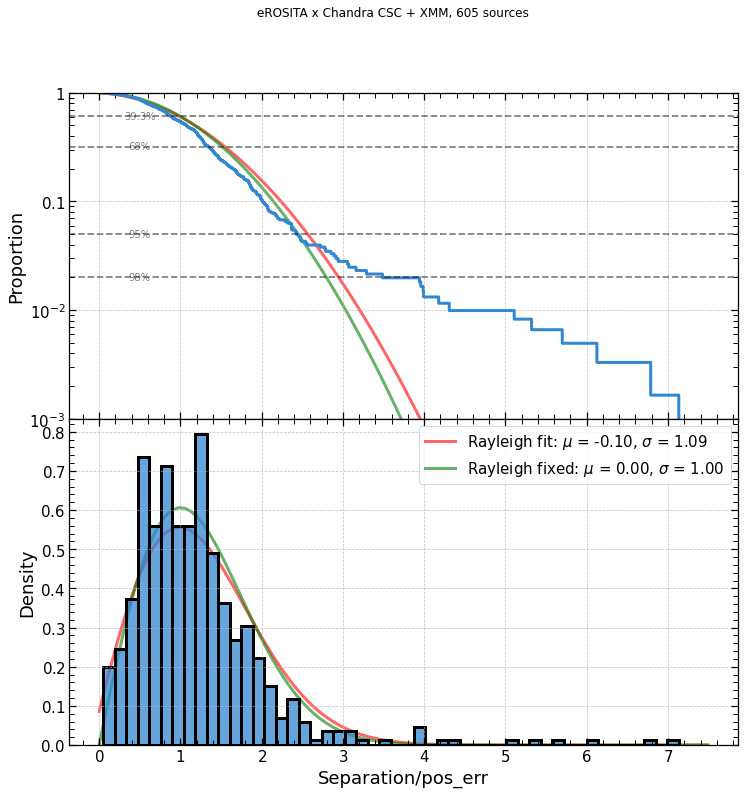

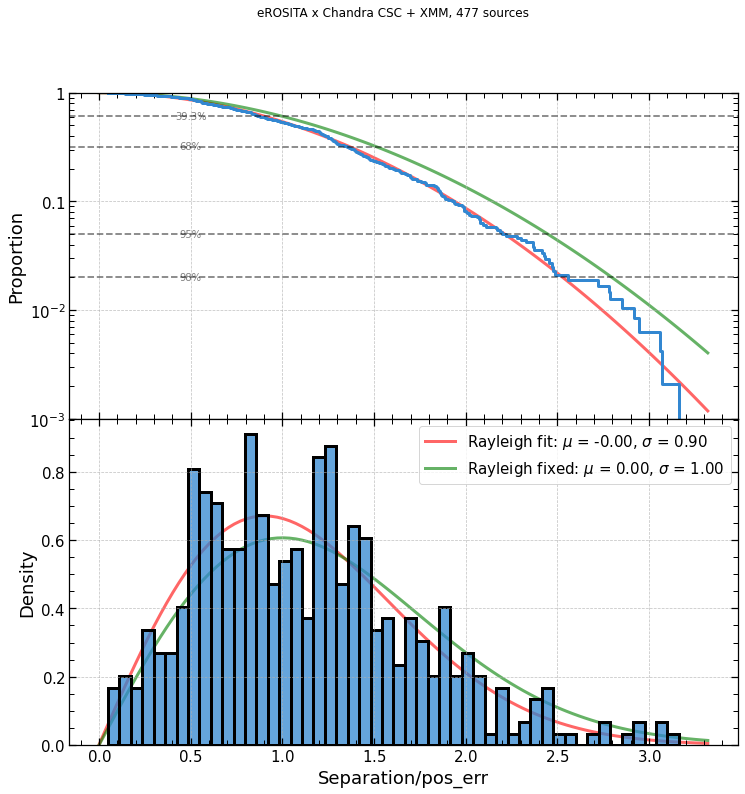

In [25]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps.query('DET_LIKE_0>15'), sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')

